# Cooling Tower Data Analysis
### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.integrate as intgr
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
### Import and clean data
I had combined all the data from day 1 and added two columns, Group and Trial. These columns ended up being trivial as the liquid flow sufficed to group the data. I then aggregated by liquid flow and calculated means and standard deviations, compiling these values in a new dataframe.

### Units
|  | Set Point Temp | Gas Flow | Liquid Flow | Outlet Water | Inlet Water | Outlet Air - Dry Bulb | Outlet Air - Wet Bulb | Inlet Air - Wet Bulb | Inlet Air - Dry Bulb |
|--------|----------------|----------|-------------|--------------|-------------|-----------------------|-----------------------|----------------------|----------------------|
| Raw | $^\circ$ C | m/s | gal/min | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C |
| Output | $^\circ$ C | kg/s | kg/s | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C | $^\circ$ C |

Most units can be readily converted to the desired output, with the exception of gas flow. Converting gas flow in m/s to kg/s requires the find the density of the inlet air, which is humid.

Perry's Handbook: Find saturation vapor pressure $p_{wb}$ at wet-bulb temperature $T_{wb}$ from Eq. (12-4). Find actual vapor
pressure $p$ at dry-bulb temperature $T$ from psychrometer equation (12-11). Find humid air density $\rho_g$ by
conversion from $p$ and $T$ (Table 12-2). All units in SI.

**12-4:** $\ln p_{wb} = −6096.9385T_{wb}^{−1} + 21.2409642 − 2.711193\times10^{−2}T_{wb} + 1.673952\times10^{−5}T_{wb}^2 + 2.433502 \ln T_{wb}$

where $T_{wb}$ is in Kelvin, $p_{wb}$ is in pascals.

**12-11:** $p = p_{wb} − AP(T − T_{wb})$

where $A$ is the psychrometric coefficient and $P$ is atmosphere pressure in Pa.

**12-11a:** $A = 6.5\times10^{−4}(1 + 0.000944T_{wb})$

Eq. 12-11a is valid for $T_{wb}$ up to 30 $^\circ$C.

**Table 12-2**: $\rho_g = \frac{P-0.378p}{287.1T}$

where $\rho_g$ is the humid air density (kg/m^3).

For Day 1 of this lab, Feb. 12, 2020, atmospheric pressure $P$ was 30.12 "Hg.

In [2]:
def get_rho(T, T_wb):
    # T = Inlet Air - Dry Bulb [Kelvin]
    # T_wb = Inlet Air - Wet Bulb [Kelvin]
    # P = 30.12 "Hg on Day 1 = 101998.03 Pa
    T = T+273.15 # convert Celsius to Kelvin
    T_wb = T_wb+273.15 # convert...
    P = 101998.03
    p_wb = np.exp(-6096.9385*T_wb**-1 + \
                  21.2409642 - 2.711193*10**-2*T_wb + \
                  1.673952*10**-5*T**2 + \
                  2.433502*np.log(T_wb))
    A = 6.5*10**-4*(1 + 0.000944*T_wb)
    p = p_wb - A*P*(T - T_wb)
    rho = (P-0.378*p)/(287.1*T)
    return rho

def get_ma(v, T, T_wb):
    rho = get_rho(T, T_wb) # kg/m^3
    V = v*np.pi/4*0.095**2 # m^3/s
    return rho*V # kg/s

In [3]:
df = pd.read_csv("Cooling Tower Day 1 - All.csv")

# Drop extra columns
df = df.drop(columns=['Group', 'Trial'])

# Aggregate for mean and std
df1 = df.groupby(['Set Point Temp','Gas Flow', 'Liquid Flow']).agg('mean').reset_index(drop=True)
df2 = df.groupby(['Set Point Temp','Gas Flow', 'Liquid Flow']).agg('std').reset_index(drop=True)
df2 = df2.rename(lambda x: x+' - std', axis=1)

# Recombine
df = df[['Set Point Temp', 'Gas Flow', 'Liquid Flow']].drop_duplicates().reset_index()
df = pd.concat([df, df1, df2], axis=1).drop(columns='index')

# Unit conversions
# Operating over a <20 degree range for water, therefore neglecting thermal expansion
df['Liquid Flow'] = df['Liquid Flow'].apply(lambda x: x*6.30902*10**-5*997)
df['Gas Flow'] = df.apply(lambda x: get_ma(x['Gas Flow'], x['Inlet Air - Dry Bulb'], x['Inlet Air - Wet Bulb']), axis=1)
df['L/G'] = df['Liquid Flow']/df['Gas Flow']
df.head()

,Set Point Temp,Gas Flow,Liquid Flow,Outlet Water,Inlet Water,Outlet Air - Dry Bulb,Outlet Air - Wet Bulb,Inlet Air - Wet Bulb,Inlet Air - Dry Bulb,Outlet Water - std,Inlet Water - std,Outlet Air - Dry Bulb - std,Outlet Air - Wet Bulb - std,Inlet Air - Wet Bulb - std,Inlet Air - Dry Bulb - std,L/G
0,45,0.016898,0.012580,31.433333,45.633333,32.800000,31.733333,14.833333,20.500000,0.208167,0.152753,0.300000,0.208167,0.057735,0.100000,0.744496
1,45,0.016896,0.025160,34.466667,45.500000,36.833333,35.833333,14.666667,20.566667,0.057735,0.100000,0.152753,0.057735,0.057735,0.057735,1.489137
2,45,0.016893,0.037741,36.700000,46.533333,39.533333,39.066667,14.633333,20.633333,0.100000,0.057735,0.057735,0.057735,0.057735,0.152753,2.234126
3,45,0.016904,0.050321,38.133333,47.500000,41.333333,41.000000,14.733333,20.400000,0.152753,0.100000,0.057735,0.100000,0.057735,0.100000,2.976842
4,45,0.016893,0.062901,39.200000,45.566667,41.700000,41.333333,14.900000,20.566667,0.100000,0.057735,0.100000,0.057735,0.000000,0.152753,3.723431


### General equations
Defined as many functions as possible. i.e. Those that won't change.
* $merkel$: Merkel equation, form that is readily integrated, i.e. instanteous evaluation
* $hsat$: Enthalpy of saturated air, form for fit equation

In [4]:
def hsat(T, a, b):
    return a*np.exp(b*T)

### Fitting $hsat$ and plotting result

In [5]:
# Empirical/fit data
hs_T = np.array([40, 50, 60, 70, 80, 90, 100, 110, 120, 130]) # F
hs_h = np.array([15.230, 20.301, 26.46, 34.09, 43.69, 55.93, 71.73, 92.34, 119.54, 155.9]) # BTU/lb dry air

def Fah2Cel(T):
    return (T-32)*5/9
def BTUpound2kJkg(x):
    return x*2.326

hs_T = Fah2Cel(hs_T)
hs_h = BTUpound2kJkg(hs_h)

# Fitting procedure
hsat_fit, hsat_cov = curve_fit(hsat, hs_T, hs_h, [0, 0])
fit_err = np.sqrt(np.diagonal(hsat_cov))

# Get fitted curve
hs_Tdata = np.linspace(hs_T[0], hs_T[-1], 100)
hs_hdata = hsat(hs_Tdata, *hsat_fit)
hs_h_errp = hsat(hs_Tdata, *hsat_fit+fit_err)
hs_h_errn = hsat(hs_Tdata, *hsat_fit-fit_err)

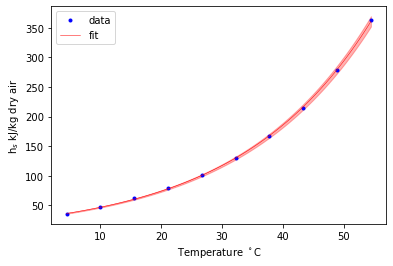

In [6]:
# Plot data and fitted curve
plt.figure(1)
plt.plot(hs_T, hs_h, 'b.')
plt.plot(hs_Tdata, hs_hdata, 'r-', linewidth=.5)
plt.xlabel('Temperature $^\circ$C')
plt.ylabel('h$_s$ kJ/kg dry air')
plt.legend(labels=['data', 'fit'])
plt.fill_between(hs_Tdata, hs_h_errp, hs_h_errn, color='r', alpha=0.3)
plt.show()

### Define air operating-line
Now that $hsat$ is fitted, $enthalpy$ can be defined

In [7]:
def enthalpy(T, Tin, Tout, LG):
    # Cp water = 4.182 kJ/kg C
    # Tout = Outlet water temperature [Celsius]
    # T = Water Temp [Celsius]
    # Tin = Wet bulb temperature in [Celsius]
    hin = hsat(Tin, *hsat_fit)
    h = hin + LG * 4.182 * (T-Tout)
    return h # [kJ/kg]

### Calculate NTU and add to Dataframes

In [8]:
def merkel(T, Tin, Tout, LG):
    h = enthalpy(T, Tin, Tout, LG)
    hs = hsat(T, *hsat_fit)
#     print(h, hs)
    return 4.182/(hs-h)

g1 = df.iloc[0:8, :].reset_index()
g2 = df.iloc[8:16, :].reset_index()
g3 = df.iloc[16:24, :].reset_index()
for g in [g1, g2, g3]:
    NTU = g.apply(lambda x: intgr.quad(merkel, x['Outlet Water'], x['Inlet Water'],
                                 args=(x['Inlet Air - Wet Bulb'], x['Outlet Water'], x['L/G'])),
             axis=1)
    NTU = NTU.apply(lambda x: x[0])
    g['NTU'] = NTU

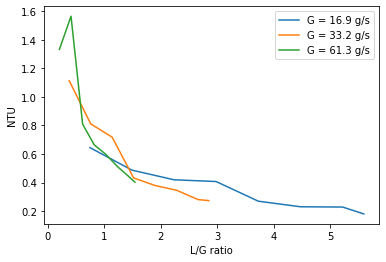

In [9]:
plt.figure(2)
for g in [g1, g2, g3]:
    plt.plot(g['L/G'], g['NTU'])
    plt.xlabel('L/G ratio')
    plt.ylabel('NTU')
plt.legend(labels=['G = 16.9 g/s', 'G = 33.2 g/s', 'G = 61.3 g/s'])
plt.show()